In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader
import numpy as np
import random
from pathlib import Path
from tqdm import tqdm

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from typing import Union, Literal
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'

/mnt/c/Users/QUAN/Desktop/gan/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAIN_PATH = Path("../")
DATA_PATH = MAIN_PATH / "data"
ARTIFACT_PATH = MAIN_PATH / "artifacts"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = os.cpu_count()
EPOCHS = 20
LEARNING_RATE = 1e-4
EPS = 1e-8
CLIP = 1.5

## Prepare Dataset

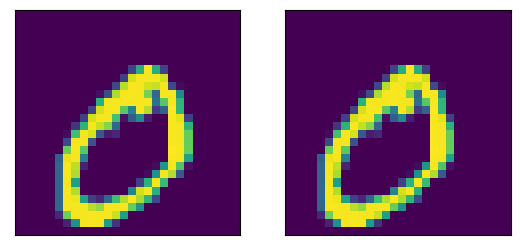

In [21]:
train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding = 4),
        transforms.ToTensor(),
      #  transforms.Normalize(0.5, 0.5)
        ])
train_dataset = datasets.MNIST(DATA_PATH, download = True, train = True, transform = train_transform)

In [22]:
mnist_idx = {digit: [] for digit in range(10)}
for idx, (_, label) in enumerate(train_dataset):
    mnist_idx[label].append(idx)

import json
with open("./deploy/jsons/mnist.json", "w") as f:
    json.dump(mnist_idx, f)
    
with open("./deploy/jsons/mnist.json", "r") as f:
    mnist_idx1 = json.load(f)

In [4]:
train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding = 4),
        transforms.ToTensor(),
      #  transforms.Normalize(0.5, 0.5)
        ])
fmnist_dataset = datasets.FashionMNIST(DATA_PATH, download = True, train = True, transform = train_transform)
fmnist_idx = {class_no: [] for class_no in range(10)}
for idx, (_, label) in enumerate(fmnist_dataset):
    fmnist_idx[label].append(idx)

import json
with open("./deploy/jsons/fmnist.json", "w") as f:
    json.dump(fmnist_idx, f)

In [5]:
train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding = 4),
        transforms.ToTensor(),
      #  transforms.Normalize(0.5, 0.5)
        ])
cifar_dataset = datasets.CIFAR10(DATA_PATH, download = True, train = True, transform = train_transform)
cifar_idx = {class_no: [] for class_no in range(10)}
for idx, (_, label) in enumerate(cifar_dataset):
    cifar_idx[label].append(idx)

import json
with open("./deploy/jsons/cifar10.json", "w") as f:
    json.dump(cifar_idx, f)

Files already downloaded and verified


In [3]:
class MNIST_Dataloader():
    def __init__(
        self,
        data_path: Union[str, Path] = DATA_PATH,
        batch_size: int = 32,
        std_normalize: bool = False,
        ):
        
        self.data_path = data_path
        self.batch_size = batch_size
        
        if std_normalize:
            train_transform = transforms.Compose([
                    transforms.RandomCrop(28, padding = 4),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=0.5, std=0.5)
                ])
            test_transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean=0.5, std=0.5)
                                                ])
        else:
            train_transform = transforms.Compose([
                    transforms.RandomCrop(28, padding = 4),
                    transforms.ToTensor(),
                ])
            test_transform = transforms.Compose([transforms.ToTensor(),
                                                ])

        self.train_dataset = datasets.MNIST(data_path, download = True, train = True, transform = train_transform)
        self.test_dataset = datasets.MNIST(data_path, download = True, train = False, transform = test_transform)
        
    def train_loader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True, drop_last=True, num_workers=NUM_WORKERS, pin_memory=True)
    
    def test_loader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

## Models

In [ ]:
class BaseVAE(nn.Module):
    def __init__(
        self,
        input_size: int = 784,
        common_size: int = 400,
        hidden_size: int = 128,
        activation: Literal["Tanh","Sigmoid"] = "Tanh",
    ):

        super(BaseVAE, self).__init__()
        self.hidden_size = hidden_size
        self.common_size = common_size
        self.flatten = nn.Flatten()
        self.encoder = nn.Linear(input_size, common_size)
        self.mean_fc = nn.Linear(common_size, hidden_size)
        self.var_fc = nn.Linear(common_size, hidden_size)
        self.decoder = nn.Sequential(nn.Linear(hidden_size, common_size), nn.ReLU(),
                                     nn.Linear(common_size, input_size))
        # self.decode_fc = nn.Linear(hidden_size, common_size)
        # self.out_fc = nn.Linear(common_size, input_size)
        self.activation = getattr(nn, activation)()
        
    def encode(self, flattened_inputs: torch.tensor) -> torch.tensor:

        x = F.relu(self.encoder(flattened_inputs))
        mu = self.mean_fc(x)
        log_var = self.var_fc(x)
        return mu, log_var
    
    def reparameterize(self, mu: torch.tensor, log_var: torch.tensor) -> torch.tensor:

        std = torch.exp(0.5*log_var) # Standard deviation of estimated P(z|x)
        eps = torch.randn_like(std) # Sample on z ~ N(0,1)
        z = mu + eps * std # Reparameterize z to on mu & std
        return z
    
    def decode(self, z: torch.tensor) -> torch.tensor:

        out = self.activation(self.decoder(z))
        return out
    
    def forward(self, inputs: torch.tensor):

        x = self.flatten(inputs)
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var
    
    def __str__(self):
        return "VAE"

In [ ]:
class Stack(nn.Module):
    def __init__(self, channels, height, width):
        super(Stack, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width

    def forward(self, x):
        return x.view(x.size(0), self.channels, self.height, self.width)

class DeepVAE(BaseVAE):
    def __init__(
        self, input_size: int = 784, common_size: int = 128, hidden_size: int = 128, alpha: float = 1.0,
        activation: Literal["Tanh","Sigmoid"] = "Tanh",
    ):
        super(DeepVAE, self).__init__(input_size, common_size, hidden_size, activation)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
            nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
            nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
            nn.Linear(128, hidden_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
            nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
            nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
            nn.Linear(392, 784),
        )
        
    def __str__(self):
        return "DeepVAE"
    

## Training

### Define Custom Loss function

In [ ]:
def BCE_VAE_loss(x_recon: torch.tensor, x: torch.tensor, mu: torch.tensor, log_var: torch.tensor, alpha=1):
    """VAE Loss using BCE for reconstruction loss

    Args:
        x_recon (torch.tensor): _description_
        x (torch.tensor): _description_
        mu (torch.tensor): _description_
        log_var (torch.tensor): _description_
        alpha (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    BCE = F.binary_cross_entropy(x_recon, x.view(x.size(0), -1), reduction="none").sum(dim=1).mean(dim=0)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean(dim=0)
    return alpha*BCE + KLD, BCE, KLD

def MSE_VAE_loss(x_recon: torch.tensor, x: torch.tensor, mu: torch.tensor, log_var: torch.tensor, alpha=1):
    """VAE Loss using MSE for reconstruction loss

    Args:
        x_recon (torch.tensor): _description_
        x (torch.tensor): _description_
        mu (torch.tensor): _description_
        log_var (torch.tensor): _description_
        alpha (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    MSE = nn.MSELoss()(x_recon, x.view(x.size(0), -1))
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean(dim=0)
    return alpha*MSE + KLD, MSE, KLD

### Utils Functions

In [7]:
def save_model(model, path: str):
    """Save Model

    Args:
        model (Callable): Model
        path (str): Path to save ckpt
    """
    torch.save(model.state_dict(), path)
    print(f"Model {str(model)} saved successfully at {path}")


def load_model(model, path: str):
    """Load Model

    Args:
        model (Callable): Model
        path (str): Path to load ckpt
    """
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    print(f"Model {str(model)} loaded successfully from {path}")
    
def plot_images(imgs):
    """Plot Images

    Args:
        imgs (Sequence): Sequence of images
    """
    fig, axs = plt.subplots(nrows=1, ncols=len(imgs), squeeze=True)
    for i in range(len(imgs)):
        img = imgs[i].detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()
    
def seed_everything(seed: int = 2023):
    """Set seed for reproducability"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def plot_images(imgs):
    fig, axs = plt.subplots(nrows=1, ncols=len(imgs), squeeze=True)
    for i in range(len(imgs)):
        img = imgs[i].detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[i].imshow(np.asarray(img))
        axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()
    
def compare_recon(original_images, recon_images):
    fig, axs = plt.subplots(nrows=2, ncols=len(original_images), squeeze=True)
    for i in range(len(original_images)):
        origin_img = original_images[i].detach()
        recon_img = recon_images[i].detach()
        origin_img = torchvision.transforms.functional.to_pil_image(origin_img)
        recon_img = torchvision.transforms.functional.to_pil_image(recon_img)
        axs[0, i].imshow(np.asarray(origin_img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[1, i].imshow(np.asarray(recon_img))
        axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

def plot_loss(total_loss: list, recon_loss: list, kld_loss: list, save_path = False):
    plt.figure(figsize = (18,6))
    
    plt.subplot(1,3,1)
    plt.plot(total_loss, color = "red")
    plt.title("Total Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    
    plt.subplot(1,3,2)
    plt.plot(recon_loss, color = "blue", label = "recon")
    plt.title("Recon Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Recon Loss")

    plt.subplot(1,3,3)
    plt.plot(kld_loss, color = "green", label = "kld")
    plt.title("KLD Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("KLD Loss")
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    

### Training/Eval Engine Functions

In [ ]:
def train(model, loss_function, train_loader, val_loader, no_epochs, learning_rate, alpha = 1, early_stopping = False, patience = 5, save = True, load = False):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
    
    model.to(DEVICE)
    print(f"Training Model on {DEVICE}")
    
    if load:
        ckpt_path = ARTIFACT_PATH / "model_ckpt" / str(model) / "model.pt"
        if not ckpt_path.exists():
            print(f"Ckpt_path for {str(model)} does not exist. Training New Model")
        else:
            load_model(model, ckpt_path)

    best_total = float("inf")
    patience_count = 0
    history = {"total_loss": [], "recon_loss": [], "kld_loss": []}
    
    for epoch in range(no_epochs):
        model.train()
        epoch_loss, recon_epoch_loss, kld_epoch_loss = 0, 0, 0
        tk0 = tqdm(train_loader, total=len(train_loader))
        for batch_idx, (images, _) in enumerate(tk0):
            images = images.to(DEVICE)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(images)
            loss, RECON, KLD = loss_function(recon_batch, images, mu, log_var, alpha = alpha)

            loss.backward()
            epoch_loss += loss.item()
            recon_epoch_loss += RECON.item()
            kld_epoch_loss += KLD.item()
            
            nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()
            # if (batch_idx + 1) % 100 == 0:
            #     print(f"Train Epoch {epoch + 1} - Total Loss = {loss.item():.4f}, Recon Loss = {RECON.item():.4f}, KLD Loss = {KLD.item():.4f}")
                
        print(f"====> Epoch {epoch + 1} Total Loss = {epoch_loss/len(train_loader):.4f}, Recon Loss = {recon_epoch_loss/len(train_loader):.4f}, KLD Loss =  {kld_epoch_loss/len(train_loader):.4f}")
        
        val_total_loss, val_recon_loss, val_kld_loss = eval(model, loss_function, val_loader, epoch, alpha=alpha)
        scheduler.step(val_total_loss)
        history["total_loss"].append(val_total_loss)
        history["recon_loss"].append(val_recon_loss)
        history["kld_loss"].append(val_kld_loss)
    
        if val_total_loss < best_total:
            print(f"{str(model)}: Val Loss improved at epoch {epoch + 1} from {best_total} to {val_total_loss}")
            best_total = val_total_loss
            patience_count = 0
            if save:
                model_path = ARTIFACT_PATH / "model_ckpt" / str(model)
                if not model_path.exists():
                    model_path.mkdir(parents=True)
                ckpt_path = str(model_path / "model.pt")
                save_model(model, ckpt_path)

        else:
            print(f"{str(model)}: Validation Accuracy from epoch {epoch + 1} did not improve")
            patience_count += 1
            if early_stopping and patience_count == patience:
                print(f"{str(model)}: No val acc improvement for {patience} consecutive epochs. Early Stopped at epoch {epoch + 1}")
        
    return history        
        
def eval(model, loss_function, val_loader, epoch = 0, alpha = 1):
    model.eval()
    with torch.no_grad():
        epoch_loss, recon_epoch_loss, kld_epoch_loss = 0, 0, 0
        for batch_idx, (images, _) in enumerate(val_loader):
            images = images.to(DEVICE)
            recon_batch, mu, log_var = model(images)
            loss, RECON, KLD = loss_function(recon_batch, images, mu, log_var, alpha=alpha)
            epoch_loss += loss.item()
            recon_epoch_loss += RECON.item()
            kld_epoch_loss += KLD.item()
            
            if batch_idx == 0:
                n = min(images.size(0), 8)
                recon_images = recon_batch.view(images.size(0), 1, 28, 28)[:n]
                compare_recon(images[:n], recon_images)
            
    return epoch_loss/len(val_loader), recon_epoch_loss/len(val_loader), kld_epoch_loss/len(val_loader)

## Simple Base VAE Model

### Train on BCELoss + KL Divergence + Sigmoid + Input Data Normalize between 0 & 1

In [ ]:
bce_model_sigmoid = BaseVAE(activation="Sigmoid")
loss = BCE_VAE_loss
data_manager = MNIST_Dataloader(batch_size = 32, std_normalize=False)
train_loader = data_manager.train_loader()
test_loader = data_manager.test_loader()

history = train(bce_model_sigmoid, loss, train_loader, test_loader, EPOCHS, LEARNING_RATE, early_stopping = False, patience = 5, save = True, load = False, alpha = 1000)
plot_loss(history["total_loss"],history["recon_loss"],history["kld_loss"])

In [ ]:
plot_loss(history["total_loss"],history["bce_loss"],history["kld_loss"])

## Inference

In [ ]:
latent_size = 20
sample_number = 10
z = torch.randn(5, latent_size)
recon_images = bce_model_sigmoid.decode(z).view(z.size(0), 1, 28, 28)
plot_images(recon_images)